In [25]:
import rioxarray
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import h5py
from rasterio.transform import from_origin
import rasterio

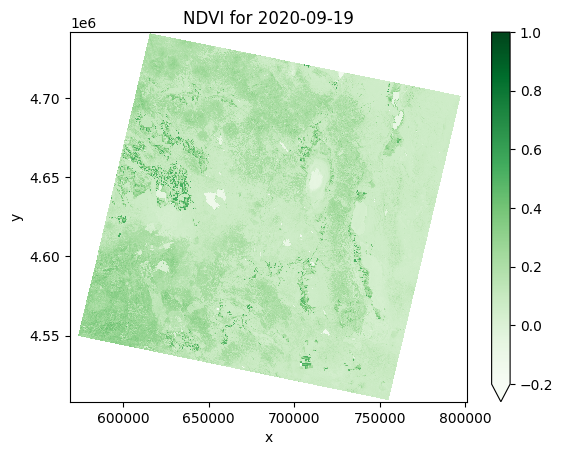

Saved ndvi_2017-09-02.tif
Saved ndvi_2020-09-10.tif
Saved ndvi_2023-09-11.tif


In [26]:
# Function to calculate NDVI
def calculate_ndvi(nir, red):
    return (nir - red) / (nir + red)

red_band_paths = [
    'data/landsat/mammoth/2017/LC08_L2SP_044031_20170902_20200903_02_T1_SR_B4.TIF', 
    'data/landsat/mammoth/2020/LC08_L2SP_044031_20200910_20200919_02_T1_SR_B4.TIF', 
    'data/landsat/mammoth/2023/LC09_L2SP_044031_20230911_20230913_02_T1_SR_B4.TIF'
]
nir_band_paths = [
    'data/landsat/mammoth/2017/LC08_L2SP_044031_20170902_20200903_02_T1_SR_B5.TIF', 
    'data/landsat/mammoth/2020/LC08_L2SP_044031_20200910_20200919_02_T1_SR_B5.TIF', 
    'data/landsat/mammoth/2023/LC09_L2SP_044031_20230911_20230913_02_T1_SR_B5.TIF'
]

red_bands = [rioxarray.open_rasterio(fp) for fp in red_band_paths]
nir_bands = [rioxarray.open_rasterio(fp) for fp in nir_band_paths]

red_data = xr.concat(red_bands, dim='time')
nir_data = xr.concat(nir_bands, dim='time')

time_index = pd.to_datetime(['2017-09-02', '2020-09-10', '2023-09-11'])

red_data = red_data.assign_coords(time=time_index)
nir_data = nir_data.assign_coords(time=time_index)

ndvi_data = calculate_ndvi(nir_data, red_data)

specific_time = '2020-09-19'
ndvi_data.sel(time=specific_time, method = 'nearest').plot(cmap='Greens', vmin=-0.2, vmax=1)
plt.title(f'NDVI for {specific_time}')
plt.show()


# export to folder
for i, time in enumerate(ndvi_data.time):
    output_path = f'ndvi_{str(time.values)[:10]}.tif'
    ndvi_slice = ndvi_data.sel(time=time)

    ndvi_slice.rio.to_raster(output_path)
    print(f'Saved {output_path}')


In [27]:
# ndvi paths
ndvi_tif_paths = ['ndvi_2017-09-02.tif', 'ndvi_2020-09-10.tif', 'ndvi_2023-09-11.tif']

dates = []
ndvi_values = []
geometries = []

for tif_path in ndvi_tif_paths:
    date_str = os.path.splitext(tif_path)[0].split('_')[1]

    ndvi_data = rioxarray.open_rasterio(tif_path)
    
    lons, lats = ndvi_data.coords['x'].values, ndvi_data.coords['y'].values
    for lon, lat in zip(lons.flatten(), lats.flatten()):
        ndvi_val = ndvi_data.sel(x=lon, y=lat, method="nearest").values.item()
        if not np.isnan(ndvi_val):  # Check for NaN values
            ndvi_values.append(ndvi_val)
            dates.append(date_str)
            geometries.append(Point(lon, lat))

# DATAFRAME
df = pd.DataFrame({'Date': dates, 'NDVI': ndvi_values})

# GDF
gdf = gpd.GeoDataFrame(df, geometry=geometries)

# Extract latitude and longitude from the geometry column
gdf['latitude'] = gdf.geometry.y
gdf['longitude'] = gdf.geometry.x

In [28]:
gdf = gdf.set_crs('EPSG:4326')

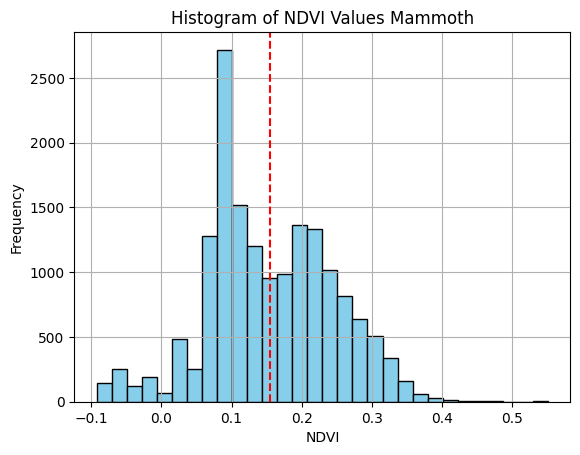

In [29]:
# fix average
# Plot histogram of NDVI values
plt.hist(gdf['NDVI'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of NDVI Values Mammoth')
plt.xlabel('NDVI')
plt.ylabel('Frequency')
plt.axvline(x=0.1546419684379297, color='red', linestyle='--', label='Value')
plt.grid(True)
plt.show()

In [30]:
average_ndvi_gdf = gdf['NDVI'].mean()
average_ndvi_gdf

0.1546419684379297

In [31]:
# 2017
gdf_2017 = gdf[gdf['Date'].str.startswith('2017')]

gdf_2017 = gdf_2017.set_crs(epsg=32610, allow_override=True)

# 2020
gdf_2020 = gdf[gdf['Date'].str.startswith('2020')]

gdf_2020 = gdf_2020.set_crs(epsg=32610, allow_override=True)

# 2023
gdf_2023 = gdf[gdf['Date'].str.startswith('2023')]

gdf_2023 = gdf_2023.set_crs(epsg=32610, allow_override=True)

In [33]:
# 2023

# load data 
soil_2023_filename = "data/soilmoisture/SMAP_L2_SM_P_E_46274_D_20230930T142228_R18290_001.h5"
h5_2023 = h5py.File(soil_2023_filename, 'r')

# get lat long and moisture
latitude_2023 = h5_2023['Soil_Moisture_Retrieval_Data/latitude'][:].flatten()
longitude_2023 = h5_2023['Soil_Moisture_Retrieval_Data/longitude'][:].flatten()
soil_moisture_2023 = h5_2023['Soil_Moisture_Retrieval_Data/soil_moisture'][:].flatten()

# make df
soil_2023_data = pd.DataFrame({'Latitude': latitude_2023, 'Longitude': longitude_2023, 'Soil Moisture': soil_moisture_2023})

# to gdf
gdf_sm_2023 = gpd.GeoDataFrame(soil_2023_data, geometry=gpd.points_from_xy(soil_2023_data.Longitude, soil_2023_data.Latitude), crs="EPSG:4326")

# drop invalid
clean_soil_moisture_2023 = gdf_sm_2023[gdf_sm_2023['Soil Moisture'] != -9999.0]

# reproject 
clean_soil_moisture_2023_reproj = clean_soil_moisture_2023.to_crs(epsg=32610)

In [34]:
# 2020 Soil moisture data 
# Load the 2020 soil moisture data
soil_2020_filename = "data/soilmoisture/SMAP_L3_SM_P_E_20200918_R19240_001.h5"
h5_2020 = h5py.File(soil_2020_filename, 'r')

# Get the data
latitude_2020 = h5_2020['Soil_Moisture_Retrieval_Data_AM/latitude'][:].flatten()
longitude_2020 = h5_2020['Soil_Moisture_Retrieval_Data_AM/longitude'][:].flatten()
soil_moisture_2020 = h5_2020['Soil_Moisture_Retrieval_Data_AM/soil_moisture'][:].flatten()

# to df
soil_2020_data = pd.DataFrame({'Latitude': latitude_2020, 'Longitude': longitude_2020, 'Soil Moisture': soil_moisture_2020})

# into gpd
gdf_sm_2020 = gpd.GeoDataFrame(soil_2020_data, geometry=gpd.points_from_xy(soil_2020_data.Longitude, soil_2020_data.Latitude), crs="EPSG:4326")

#drop
clean_soil_moisture_2020 = gdf_sm_2020[gdf_sm_2020['Soil Moisture'] != -9999.0]
# reproject
clean_soil_moisture_2020_reproj = clean_soil_moisture_2020.to_crs(epsg=32610)

In [35]:
# 2017 Soil moisture data 
# Load the 2017 soil moisture data
soil_2017_filename = "data/soilmoisture/SMAP_L3_SM_P_E_20170917_R19240_001.h5"
h5_2017 = h5py.File(soil_2017_filename, 'r')

# extract lat, long, soil moisture
latitude_2017 = h5_2017['Soil_Moisture_Retrieval_Data_AM/latitude'][:].flatten()
longitude_2017 = h5_2017['Soil_Moisture_Retrieval_Data_AM/longitude'][:].flatten()
soil_moisture_2017 = h5_2017['Soil_Moisture_Retrieval_Data_AM/soil_moisture'][:].flatten()

# into dataframe
soil_2017_data = pd.DataFrame({'Latitude': latitude_2017, 'Longitude': longitude_2017, 'Soil Moisture': soil_moisture_2017})

# into gpd
gdf_sm_2017 = gpd.GeoDataFrame(soil_2017_data, geometry=gpd.points_from_xy(soil_2017_data.Longitude, soil_2017_data.Latitude), crs="EPSG:4326")

# get rid of -9999.0
clean_soil_moisture_2017 = gdf_sm_2017[gdf_sm_2017['Soil Moisture'] != -9999.0]

# Reproject
clean_soil_moisture_2017_reproj = clean_soil_moisture_2017.to_crs(epsg=32610)

# MERGE

In [56]:
# 2023
buffer_distance = 1000  # Specify the buffer distance in CRS units (metre)
clean_soil_moisture_2023_reproj['Buffered Geometry'] = clean_soil_moisture_2023_reproj.geometry.buffer(buffer_distance)
clean_soil_moisture_2023_reproj.geometry = clean_soil_moisture_2023_reproj['Buffered Geometry']

mammoth_merge_2023 = clean_soil_moisture_2023_reproj.sjoin(gdf_2023, how="inner")

In [59]:
mammoth_merge_2023.shape

(858, 10)

In [77]:
# 2017
buffer_distance = 5000  
clean_soil_moisture_2017_reproj['Buffered Geometry'] = clean_soil_moisture_2017_reproj.geometry.buffer(buffer_distance)
clean_soil_moisture_2017_reproj.geometry = clean_soil_moisture_2017_reproj['Buffered Geometry']

mammoth_merge_2017 = clean_soil_moisture_2017_reproj.sjoin(gdf_2017, how="inner")

In [39]:
mammoth_merge_2017

,Latitude,Longitude,Soil Moisture,geometry,Buffered Geometry,index_right,Date,NDVI,latitude,longitude


In [63]:
# 2020
buffer_distance_2020 = 1000  
clean_soil_moisture_2020_reproj['Buffered Geometry'] = clean_soil_moisture_2020_reproj.geometry.buffer(buffer_distance_2020)
clean_soil_moisture_2020_reproj.geometry = clean_soil_moisture_2020_reproj['Buffered Geometry']

mammoth_merge_2020 = clean_soil_moisture_2020_reproj.sjoin(gdf_2020, how="inner")

In [64]:
mammoth_merge_2020.shape

(1832, 10)

# Correlation


In [42]:
correlation_coefficient_2020 = mammoth_merge_2020['NDVI'].corr(mammoth_merge_2020['Soil Moisture'])

print(correlation_coefficient_2020)

-0.2979412743045646


In [43]:
average_ndvi_2020 = mammoth_merge_2020['NDVI'].mean()
average_ndvi_2020

0.09517134443845555

In [44]:
correlation_coefficient_2017 = mammoth_merge_2017['NDVI'].corr(mammoth_merge_2017['Soil Moisture'])

print(correlation_coefficient_2017)

nan


In [45]:
correlation_coefficient_2023 = mammoth_merge_2023['NDVI'].corr(mammoth_merge_2023['Soil Moisture'])

print(correlation_coefficient_2023)

-0.3219413827582549


# Add correlation column 

In [69]:
# add column to merged_xxxx of correlation 
correlation_2017 = mammoth_merge_2017['NDVI'].corr(mammoth_merge_2017['Soil Moisture'])

# Add correlation column to GeoDataFrame
mammoth_merge_2017['Correlation'] = correlation_2017
mammoth_merge_2017

,Latitude,Longitude,Soil Moisture,geometry,Buffered Geometry,index_right,Date,NDVI,latitude,longitude,Correlation


In [76]:
# add column to merged_xxxx of correlation 
correlation_2020 = mammoth_merge_2020['NDVI'].corr(mammoth_merge_2020['Soil Moisture'])

# Add correlation column to GeoDataFrame
mammoth_merge_2020['Correlation'] = correlation_2020

In [71]:
# add column to merged_xxxx of correlation 
correlation_2023 = mammoth_merge_2023['NDVI'].corr(mammoth_merge_2023['Soil Moisture'])

# Add correlation column to GeoDataFrame
mammoth_merge_2023['Correlation'] = correlation_2023
mammoth_merge_2023

,Latitude,Longitude,Soil Moisture,geometry,Buffered Geometry,index_right,Date,NDVI,latitude,longitude,Correlation
183359,41.105053,-121.696060,0.270754,"POLYGON ((611489.127 4551287.288, 611489.127 4...","POLYGON ((611489.127 4551287.288, 611489.127 4...",11193,2023-09-11,0.275598,4549260.0,609660.0,-0.409954
183359,41.105053,-121.696060,0.270754,"POLYGON ((611489.127 4551287.288, 611489.127 4...","POLYGON ((611489.127 4551287.288, 611489.127 4...",11194,2023-09-11,0.295601,4549290.0,609690.0,-0.409954
183359,41.105053,-121.696060,0.270754,"POLYGON ((611489.127 4551287.288, 611489.127 4...","POLYGON ((611489.127 4551287.288, 611489.127 4...",11195,2023-09-11,0.305400,4549320.0,609720.0,-0.409954
183359,41.105053,-121.696060,0.270754,"POLYGON ((611489.127 4551287.288, 611489.127 4...","POLYGON ((611489.127 4551287.288, 611489.127 4...",11196,2023-09-11,0.269222,4549350.0,609750.0,-0.409954
183359,41.105053,-121.696060,0.270754,"POLYGON ((611489.127 4551287.288, 611489.127 4...","POLYGON ((611489.127 4551287.288, 611489.127 4...",11197,2023-09-11,0.279013,4549380.0,609780.0,-0.409954
...,...,...,...,...,...,...,...,...,...,...,...
190757,42.422539,-119.828835,0.256728,"POLYGON ((762894.750 4701614.158, 762894.750 4...","POLYGON ((762894.750 4701614.158, 762894.750 4...",16291,2023-09-11,0.104379,4702200.0,762600.0,-0.409954
190757,42.422539,-119.828835,0.256728,"POLYGON ((762894.750 4701614.158, 762894.750 4...","POLYGON ((762894.750 4701614.158, 762894.750 4...",16292,2023-09-11,0.093704,4702230.0,762630.0,-0.409954
190757,42.422539,-119.828835,0.256728,"POLYGON ((762894.750 4701614.158, 762894.750 4...","POLYGON ((762894.750 4701614.158, 762894.750 4...",16293,2023-09-11,0.089090,4702260.0,762660.0,-0.409954
190757,42.422539,-119.828835,0.256728,"POLYGON ((762894.750 4701614.158, 762894.750 4...","POLYGON ((762894.750 4701614.158, 762894.750 4...",16294,2023-09-11,0.092886,4702290.0,762690.0,-0.409954


# Merge 

In [74]:
mammoth_merged_gdf = gpd.GeoDataFrame(pd.concat([mammoth_merge_2017, mammoth_merge_2020, mammoth_merge_2023], ignore_index=True))

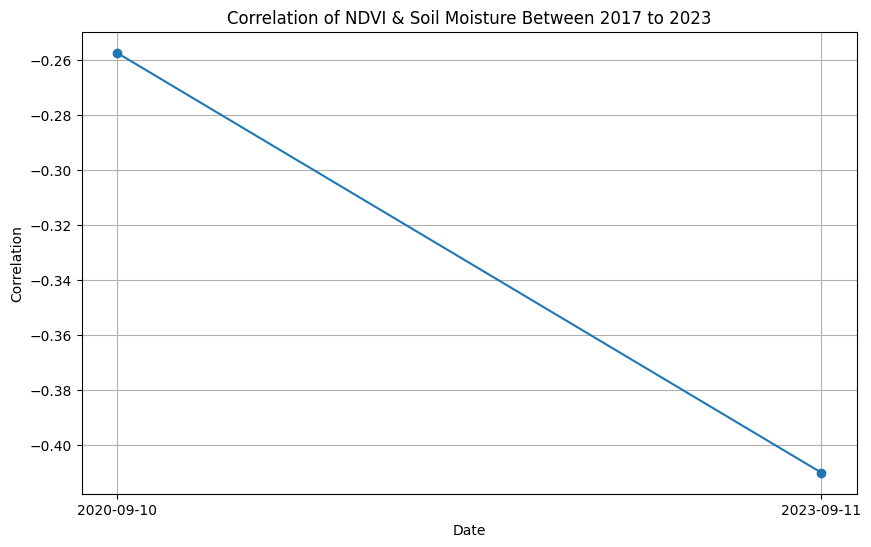

In [75]:
grouped = mammoth_merged_gdf.groupby('Date')['Correlation'].mean()

# Plotting the correlation over time
plt.figure(figsize=(10, 6))
plt.plot(grouped.index, grouped, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.title('Correlation of NDVI & Soil Moisture Between 2017 to 2023')
plt.grid(True)
plt.show()